## Import Library

In [37]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [38]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [39]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

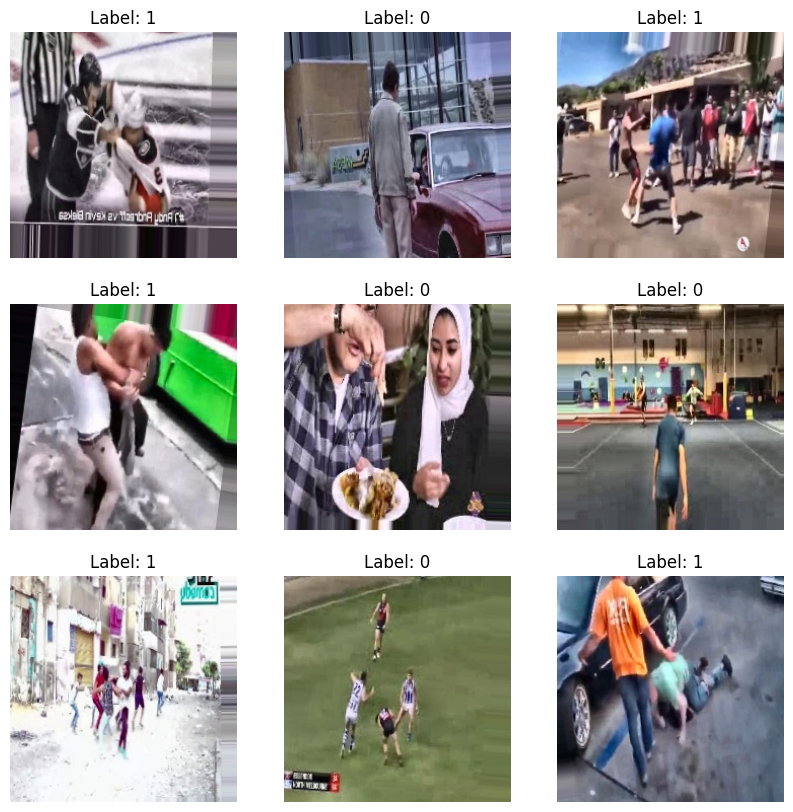

In [40]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [41]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Freeze
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_FreezeAll_0.01.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [42]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7108 - loss: 1.4184
Epoch 1: val_accuracy improved from -inf to 0.66364, saving model to MCLAHE_FreezeAll_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 652ms/step - accuracy: 0.7121 - loss: 1.4160 - val_accuracy: 0.6636 - val_loss: 1.5123
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8583 - loss: 0.9846
Epoch 2: val_accuracy improved from 0.66364 to 0.76818, saving model to MCLAHE_FreezeAll_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.8580 - loss: 0.9836 - val_accuracy: 0.7682 - val_loss: 0.9345
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8665 - loss: 0.7480
Epoch 3: val_accuracy improved from 0.76818 to 0.77955, saving model to MCLAHE_FreezeAll_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 589ms/step - accuracy: 0.8665 - loss: 0.7483 - val_accuracy: 0.7795 - val_loss: 0.9450
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8662 - loss: 0.8413
Epoch 4: val_accuracy did not improve from 0.77955
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.8662 - loss: 0.8412 - val_accuracy: 0.7682 - val_loss: 0.9444
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8610 - loss: 0.8078
Epoch 5: val_accuracy did not improve from 0.77955
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 555ms/step - accuracy: 0.8607 - loss: 0.8083 - val_accuracy: 0.7386 - val_loss: 0.9714
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8854 - loss: 0.7025
Epoch 6: val_accuracy improved from 0.77955 to 0.88182, saving model to MCLAHE_FreezeAll_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 550ms/step - accuracy: 0.8854 - loss: 0.7019 - val_accuracy: 0.8818 - val_loss: 0.7000
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8927 - loss: 0.7139
Epoch 7: val_accuracy improved from 0.88182 to 0.90227, saving model to MCLAHE_FreezeAll_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.8927 - loss: 0.7140 - val_accuracy: 0.9023 - val_loss: 0.6825
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8882 - loss: 0.7057
Epoch 8: val_accuracy did not improve from 0.90227
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 569ms/step - accuracy: 0.8880 - loss: 0.7057 - val_accuracy: 0.8977 - val_loss: 0.6017
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8897 - loss: 0.6379
Epoch 9: val_accuracy did not improve from 0.90227
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.8897 - loss: 0.6376 - val_accuracy: 0.8364 - val_loss: 0.6793
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9130 - loss: 0.5510
Epoch 10: val_accuracy did not improve from 0.90227
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.9124 - loss: 0.5516 - val_accuracy: 0.7636 - val_loss: 0.8741
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8838 - loss: 0.6132
Epoch 11: val_accuracy did n

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8704 - loss: 0.6104
Validation Loss: 0.5479418039321899
Validation Accuracy: 0.8977272510528564


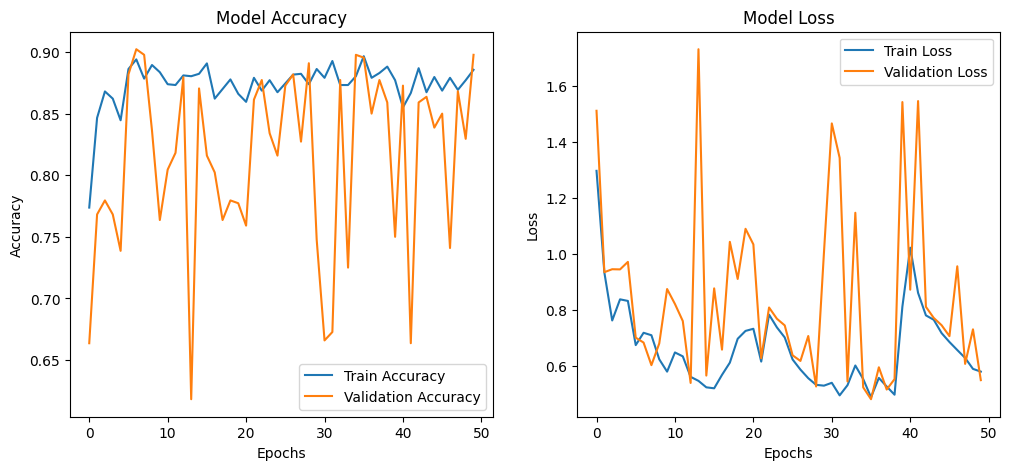

In [43]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [44]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_FreezeAll_0.01.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.8793 - loss: 0.7258
Test Accuracy : 88.74%
Test Loss     : 0.702


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step


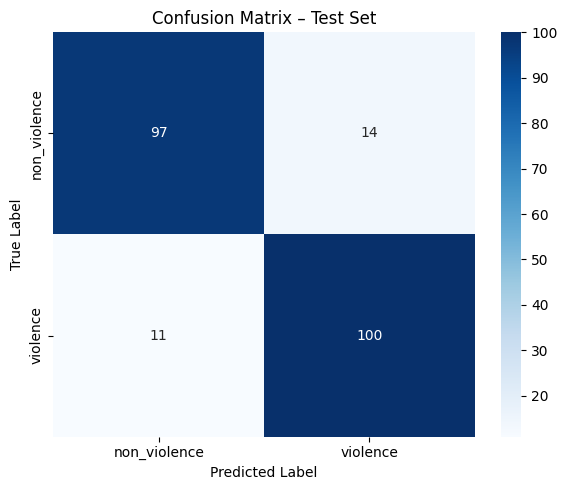


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.90      0.87      0.89       111
    violence       0.88      0.90      0.89       111

    accuracy                           0.89       222
   macro avg       0.89      0.89      0.89       222
weighted avg       0.89      0.89      0.89       222



In [45]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))